# Sistema de Control Discreto - Análisis de Estabilidad

## Sistema Original Continuo

Para un sistema con realimentación unitaria:

$G(s) = \frac{K(s^2-5s+12)}{(s+5)(s^2+7s+6)}$

**Parámetros de discretización:**
- Período de muestreo: $T_s = 0.5$ segundos
- Frecuencia de muestreo: $f_s = 2$ Hz
- Método: Zero-Order Hold (ZOH)


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl
from scipy import signal
import sympy as sp
from sympy import symbols, expand, solve, Poly
import warnings
warnings.filterwarnings('ignore')

# Configuración de matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11


## 1. Discretización de la Función de Transferencia


In [16]:
# Parámetros del sistema
Ts = 0.5  # Período de muestreo en segundos
K = 1.0   # Ganancia inicial para análisis

# Función de transferencia continua
num_cont = [K, -5*K, 12*K]  # K(s^2 - 5s + 12)
den_cont = [1, 12, 41, 30]  # (s+5)(s^2+7s+6) = s^3 + 12s^2 + 41s + 30

# Sistema continuo
G_cont = ctrl.TransferFunction(num_cont, den_cont)
print("Sistema continuo G(s):")
print(G_cont)

# Discretización usando scipy.signal.cont2discrete con ZOH
num_disc, den_disc, _ = signal.cont2discrete((num_cont, den_cont), Ts, method='zoh')

# Convertir a arrays 1D (quitar dimensiones extra)
num_disc = num_disc.flatten()
den_disc = den_disc.flatten()

# Crear sistema discreto
G_disc = ctrl.TransferFunction(num_disc, den_disc, dt=Ts)
print(f"\nSistema discreto G(z) con Ts = {Ts}s:")
print(G_disc)

# Función de transferencia de lazo cerrado continua
T_cont = ctrl.feedback(G_cont, 1)
print("\nFunción de transferencia de lazo cerrado continua T(s):")
print(T_cont)

# Función de transferencia de lazo cerrado discreta
T_disc = ctrl.feedback(G_disc, 1)
print(f"\nFunción de transferencia de lazo cerrado discreta T(z):")
print(T_disc)


Sistema continuo G(s):
<TransferFunction>: sys[6]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


     s^2 - 5 s + 12
------------------------
s^3 + 12 s^2 + 41 s + 30


Sistema discreto G(z) con Ts = 0.5s:
<TransferFunction>: sys[7]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


   -0.02086 z^2 + 0.1196 z + 0.03852
---------------------------------------
z^3 - 0.7384 z^2 + 0.08407 z - 0.002479

dt = 0.5


Función de transferencia de lazo cerrado continua T(s):
<TransferFunction>: sys[9]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


     s^2 - 5 s + 12
------------------------
s^3 + 13 s^2 + 36 s + 42


Función de transferencia de lazo cerrado discreta T(z):
<TransferFunction>: sys[11]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


  -0.02086 z^2 + 0.1196 z + 0.03852
-------------------------------------
z^3 - 0.7593 z^2 + 0.2037 z + 0.03604

dt = 0.5



## Análisis de Estabilidad en el Dominio z

Para sistemas discretos, la condición de estabilidad es que **todos los polos estén dentro del círculo unitario**: $|z| < 1$

### Transformación de criterios de estabilidad:
- **Continuo**: $\text{Re}(s) < 0$ (semiplano izquierdo)
- **Discreto**: $|z| < 1$ (interior del círculo unitario)

### Transformación bilineal para análisis de Routh-Hurwitz

Para aplicar el criterio de Routh-Hurwitz en sistemas discretos, usamos la transformación bilineal:

$$z = \frac{1 + w}{1 - w}$$

donde $w$ es la nueva variable. Los polos estables en el plano z ($|z| < 1$) se mapean al semiplano izquierdo en el plano w ($\text{Re}(w) < 0$).


In [34]:
def discretize_system_symbolic(K_val):
    """Discretiza el sistema para un valor específico de K"""
    num_cont = [K_val, -5*K_val, 12*K_val]
    den_cont = [1, 12, 41, 30]
    
    # Discretización
    num_disc, den_disc, _ = signal.cont2discrete((num_cont, den_cont), Ts, method='zoh')
    
    # Convertir a arrays 1D
    num_disc = num_disc.flatten()
    den_disc = den_disc.flatten()
    
    G_disc = ctrl.TransferFunction(num_disc, den_disc, dt=Ts)
    T_disc = ctrl.feedback(G_disc, 1)
    
    return G_disc, T_disc

# Ejemplo con K = 1
G_d, T_d = discretize_system_symbolic(1.0)
print("Polos del sistema discreto de lazo cerrado con K=1.010:")
polos_discretos = ctrl.poles(T_d)
print(polos_discretos)
print("\nMagnitudes de los polos:")
magnitudes = np.abs(polos_discretos)
for i, (polo, mag) in enumerate(zip(polos_discretos, magnitudes)):
    print(f"Polo {i+1}: {polo:.4f}, |z| = {mag:.4f}")
    
estable = all(mag < 1.0 for mag in magnitudes)
print(f"\nEl sistema es {'ESTABLE' if estable else 'INESTABLE'} con K=1.010")


Polos del sistema discreto de lazo cerrado con K=1.010:
[ 0.43838674+0.33842795j  0.43838674-0.33842795j -0.11751028+0.j        ]

Magnitudes de los polos:
Polo 1: 0.4384+0.3384j, |z| = 0.5538
Polo 2: 0.4384-0.3384j, |z| = 0.5538
Polo 3: -0.1175+0.0000j, |z| = 0.1175

El sistema es ESTABLE con K=1.010


In [20]:
def analyze_discrete_stability_range():
    """Analiza el rango de estabilidad del sistema discreto"""
    
    # Rango de valores de K para analizar
    K_values = np.linspace(-5, 10, 1000)
    max_pole_magnitude = []
    
    print("Analizando estabilidad para diferentes valores de K...")
    
    for K in K_values:
        try:
            _, T_d = discretize_system_symbolic(K)
            polos = ctrl.poles(T_d)
            max_mag = np.max(np.abs(polos))
            max_pole_magnitude.append(max_mag)
        except:
            max_pole_magnitude.append(np.inf)
    
    max_pole_magnitude = np.array(max_pole_magnitude)
    
    # Encontrar los límites de estabilidad
    stable_indices = max_pole_magnitude < 1.0
    
    if np.any(stable_indices):
        stable_K = K_values[stable_indices]
        K_min_stable = np.min(stable_K)
        K_max_stable = np.max(stable_K)
        
        print(f"Rango de estabilidad aproximado: {K_min_stable:.3f} < K < {K_max_stable:.3f}")
    
    return K_values, max_pole_magnitude

K_vals, pole_mags = analyze_discrete_stability_range()


Analizando estabilidad para diferentes valores de K...
Rango de estabilidad aproximado: -2.492 < K < 5.691


##  Análisis de Estabilidad para Diferentes Valores de K


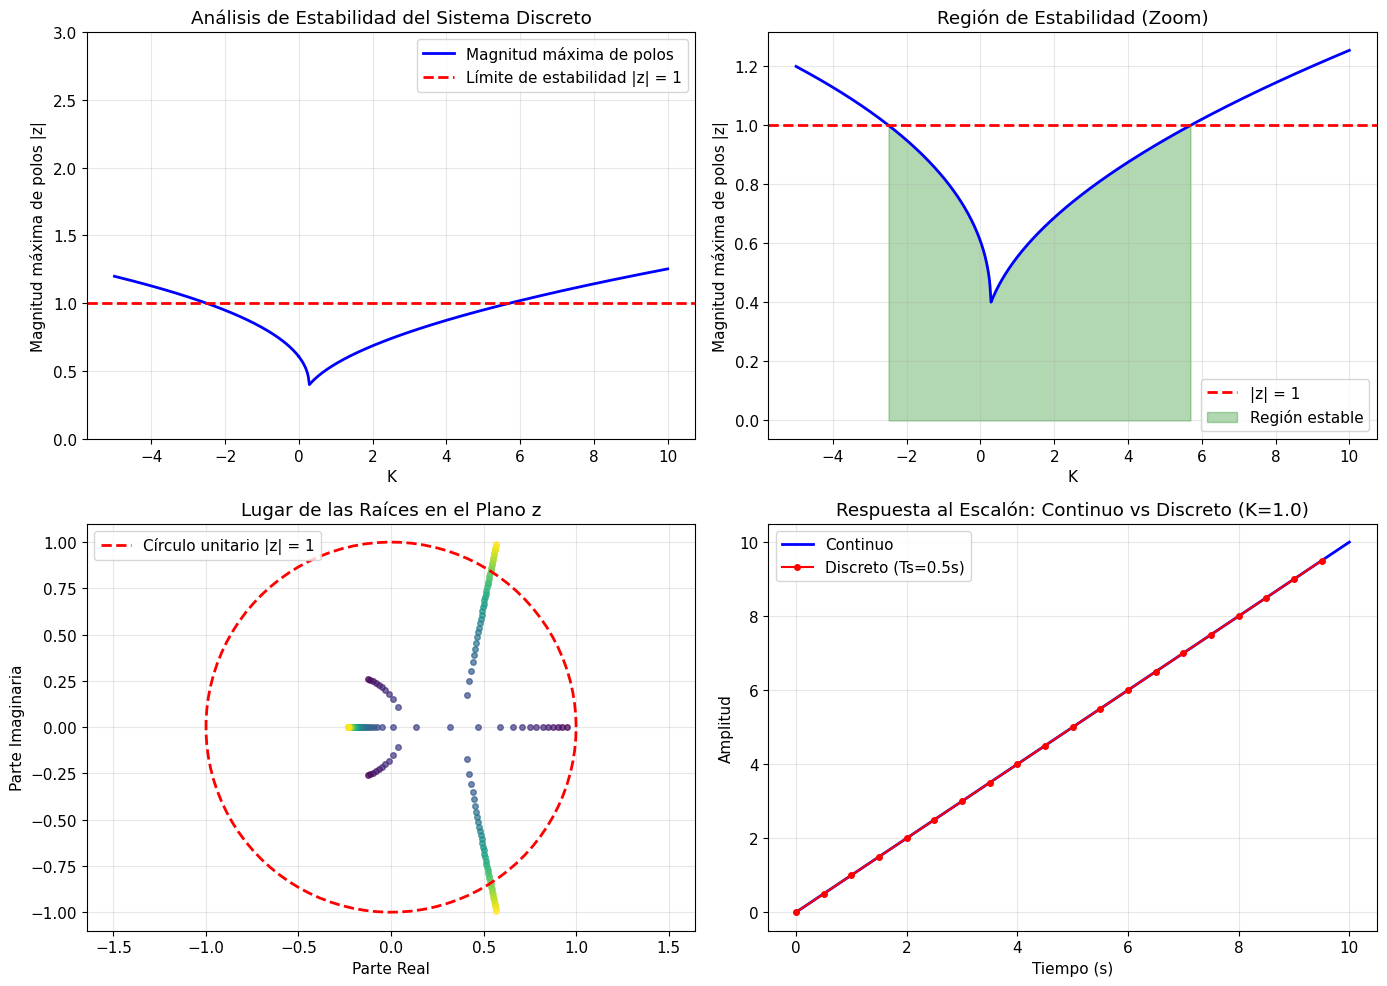

In [21]:
# Gráfica de magnitud máxima de polos vs K
plt.figure(figsize=(14, 10))

# Subplot 1: Magnitud máxima de polos vs K
plt.subplot(2, 2, 1)
plt.plot(K_vals, pole_mags, 'b-', linewidth=2, label='Magnitud máxima de polos')
plt.axhline(y=1, color='r', linestyle='--', linewidth=2, label='Límite de estabilidad |z| = 1')
plt.xlabel('K')
plt.ylabel('Magnitud máxima de polos |z|')
plt.title('Análisis de Estabilidad del Sistema Discreto')
plt.grid(True, alpha=0.3)
plt.legend()
plt.ylim(0, 3)

# Subplot 2: Zoom en la región de estabilidad
plt.subplot(2, 2, 2)
stable_region = pole_mags < 2  # Zoom en región relevante
plt.plot(K_vals[stable_region], pole_mags[stable_region], 'b-', linewidth=2)
plt.axhline(y=1, color='r', linestyle='--', linewidth=2, label='|z| = 1')
plt.fill_between(K_vals[stable_region], 0, pole_mags[stable_region], 
                 where=(pole_mags[stable_region] < 1), alpha=0.3, color='green', label='Región estable')
plt.xlabel('K')
plt.ylabel('Magnitud máxima de polos |z|')
plt.title('Región de Estabilidad (Zoom)')
plt.grid(True, alpha=0.3)
plt.legend()

# Subplot 3: Lugar de las raíces en el plano z
plt.subplot(2, 2, 3)
K_test_values = np.linspace(-2, 8, 50)
colors = plt.cm.viridis(np.linspace(0, 1, len(K_test_values)))

for i, K in enumerate(K_test_values):
    try:
        _, T_d = discretize_system_symbolic(K)
        polos = ctrl.poles(T_d)
        plt.plot(np.real(polos), np.imag(polos), 'o', color=colors[i], markersize=4, alpha=0.7)
    except:
        continue

# Círculo unitario
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), 'r--', linewidth=2, label='Círculo unitario |z| = 1')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.title('Lugar de las Raíces en el Plano z')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.legend()

# Subplot 4: Comparación continuo vs discreto
plt.subplot(2, 2, 4)
K_comp = 1.0
G_cont_comp = ctrl.TransferFunction([K_comp, -5*K_comp, 12*K_comp], [1, 12, 41, 30])

# Discretización para comparación
num_disc_comp, den_disc_comp, _ = signal.cont2discrete(([K_comp, -5*K_comp, 12*K_comp], [1, 12, 41, 30]), Ts, method='zoh')

# Convertir a arrays 1D
num_disc_comp = num_disc_comp.flatten()
den_disc_comp = den_disc_comp.flatten()

G_disc_comp = ctrl.TransferFunction(num_disc_comp, den_disc_comp, dt=Ts)

t_cont = np.linspace(0, 10, 1000)
t_disc = np.arange(0, 10, Ts)

T_cont_comp = ctrl.feedback(G_cont_comp, 1)
T_disc_comp = ctrl.feedback(G_disc_comp, 1)

y_cont, _ = ctrl.step_response(T_cont_comp, t_cont)
y_disc, _ = ctrl.step_response(T_disc_comp, t_disc)

plt.plot(t_cont, y_cont, 'b-', linewidth=2, label='Continuo')
plt.plot(t_disc, y_disc, 'ro-', markersize=4, linewidth=1.5, label=f'Discreto (Ts={Ts}s)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title(f'Respuesta al Escalón: Continuo vs Discreto (K={K_comp})')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()
